Bias/variance of non-parametric models
======================================

*Fraida Fund*

**Attribution**: Parts of this notebook are adopted from: [Single estimator versus bagging: bias-variance decomposition](https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import BaggingRegressor,AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

Generate data
-------------

We will generate data from the true function

$$ t(x) = e^{-x^2} + 1.5 e^{-(x-2)^2}$$

in the range $-5 < x < 5$.

To this we will add Gaussian noise $\epsilon$ so that

$$ y = t(x) + \epsilon$$

We will use this data for *all* of the models trained in this notebook.

In [13]:
# Utility functions to generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)
    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))
        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))
    return X, y

Set up simulation
-----------------

In [14]:
# Simulation settings
n_repeat = 500       # Number of iterations for computing expectations
n_train  = 500        # Size of the training set
n_test   = 1000       # Size of the test set
noise    = 0.15       # Standard deviation of the noise
np.random.seed(4)

In [15]:
def plot_simulation(estimators):

  n_estimators = len(estimators)
  plt.figure(figsize=(5*n_estimators, 10))

  # Loop over estimators to compare
  for n, (name, estimator) in enumerate(estimators):
      # Compute predictions
      y_predict = np.zeros((n_test, n_repeat))

      for i in range(n_repeat):
          estimator.fit(X_train[i].reshape(-1,1), y_train[i])
          y_predict[:, i] = estimator.predict(X_test.reshape(-1,1))

      # Bias^2 + Variance + Noise decomposition of the mean squared error
      y_error = np.zeros(n_test)

      for i in range(n_repeat):
          for j in range(n_repeat):
              y_error += (y_test[:, j] - y_predict[:, i]) ** 2

      y_error /= (n_repeat * n_repeat)

      y_noise = np.var(y_test, axis=1)
      y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
      y_var = np.var(y_predict, axis=1)

      # Plot figures
      plt.subplot(2, n_estimators, n + 1)
      plt.plot(X_test, f(X_test), "b", label="$f(x)$")
      plt.plot(X_train[0], y_train[0],  ".b", alpha=0.2, label="$y = f(x)+noise$")

      for i in range(20):
          if i == 0:
              plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
          else:
              plt.plot(X_test, y_predict[:, i], "r", alpha=0.1)

      plt.plot(X_test, np.mean(y_predict, axis=1), "c",
              label=r"$E[ \^y(x)]$")

      plt.xlim([-5, 5])
      plt.title(name)

      if n == n_estimators - 1:
          plt.legend(loc=(1.1, .5))

      plt.subplot(2, n_estimators, n_estimators + n + 1)
      plt.plot(X_test, y_noise, "c", label="$noise(x)$", alpha=0.3)
      plt.plot(X_test, y_bias, "b", label="$bias^2(x)$", alpha=0.6),
      plt.plot(X_test, y_var, "g", label="$variance(x)$", alpha=0.6),
      plt.plot(X_test, y_error, "r", label="$error(x)$", alpha=0.4)
      plt.title("{0:.4f} (error) = {1:.4f} (bias^2) \n"
            " + {2:.4f} (var) + {3:.4f} (noise)".format( np.mean(y_error),
                                                        np.mean(y_bias),
                                                        np.mean(y_var),
                                                        np.mean(y_noise)))

      plt.xlim([-5, 5])
      plt.ylim([0, 0.1])

      if n == n_estimators - 1:

          plt.legend(loc=(1.1, .5))

  plt.subplots_adjust(right=.75)

In [16]:
X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

In [17]:
X_train = np.zeros(shape=(n_repeat, n_train))
y_train = np.zeros(shape=(n_repeat, n_train))

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train[i] = X.ravel()
    y_train[i] = y

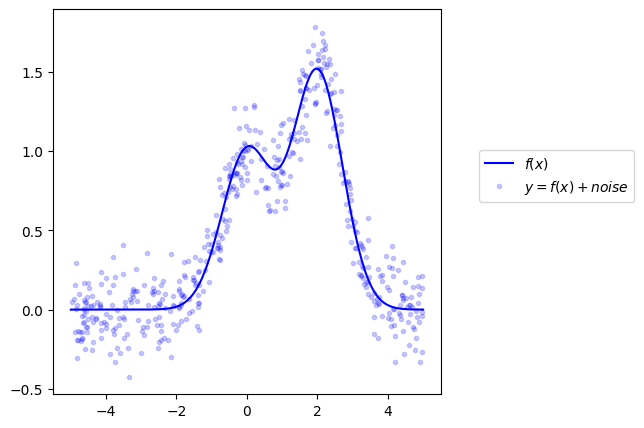

In [18]:
plt.figure(figsize=(5,5))
plt.plot(X_test, f(X_test), "b", label="$f(x)$");
plt.plot(X_train[0], y_train[0],  ".b", alpha=0.2, label="$y = f(x)+noise$");
plt.legend(loc=(1.1, .5));

K Nearest Neighbors
-------------------

Consider the following KNN regression models. Which model will have more bias? Which model will have more variance?

-   **Model A**: K = 1
-   **Model B**: K = 75

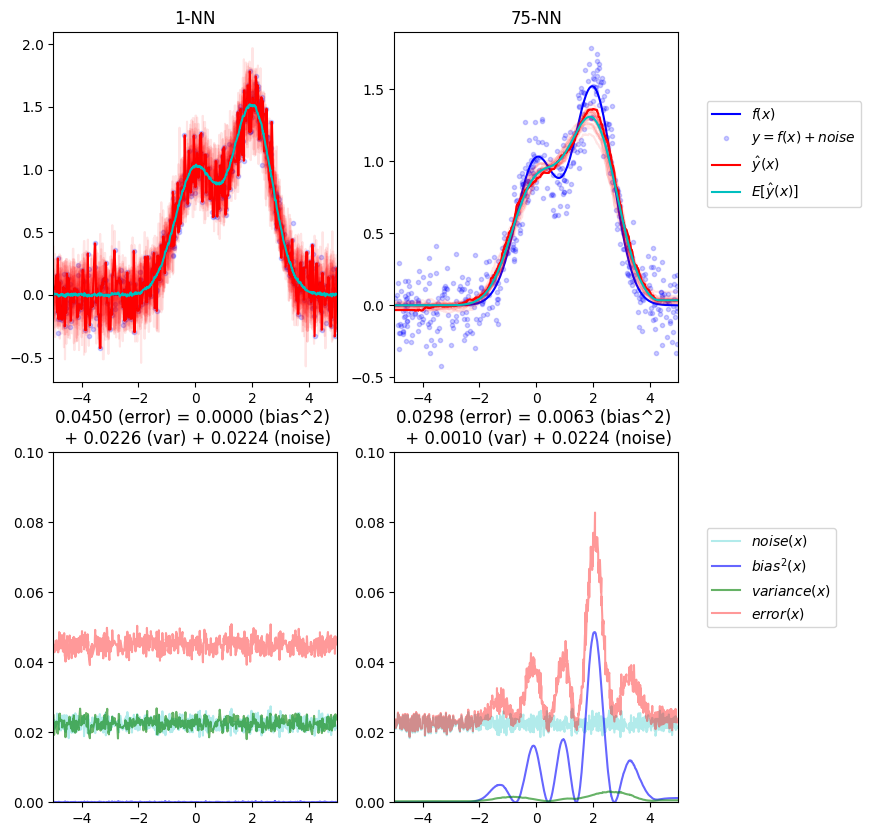

In [19]:
estimators = [("1-NN", KNeighborsRegressor(n_neighbors=1)),
              ("75-NN", KNeighborsRegressor(n_neighbors=75))]

plot_simulation(estimators)

Decision tree by depth
----------------------

Consider the following decision tree regression models. Which model will have more bias? Which model will have more variance?

-   **Model A**: Max depth = 5
-   **Model B**: Max depth = 100

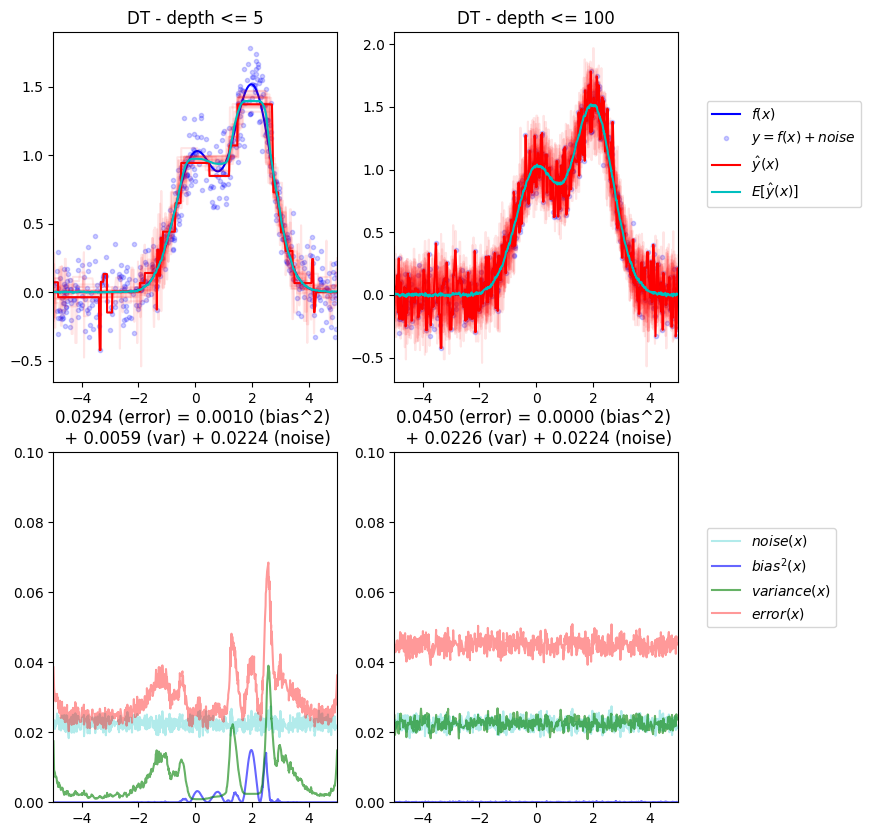

In [20]:
estimators = [("DT - depth <= 5",  DecisionTreeRegressor(max_depth=5)),
              ("DT - depth <= 100", DecisionTreeRegressor(max_depth=100))]

plot_simulation(estimators)

Decision tree by pruning parameter
----------------------------------

Suppose we use cost complexity tuning to train the decision tree that minimizes

$$\sum_{m=1}^{|T|} \sum_{x_i}^{R_m} (y_i - \hat{y}_{R_m})^2 + \alpha |T| $$

Consider the following decision tree regression models. Which model will have more bias? Which model will have more variance?

-   **Model A**: $\alpha = 0.00001$
-   **Model B**: $\alpha = 0.001$

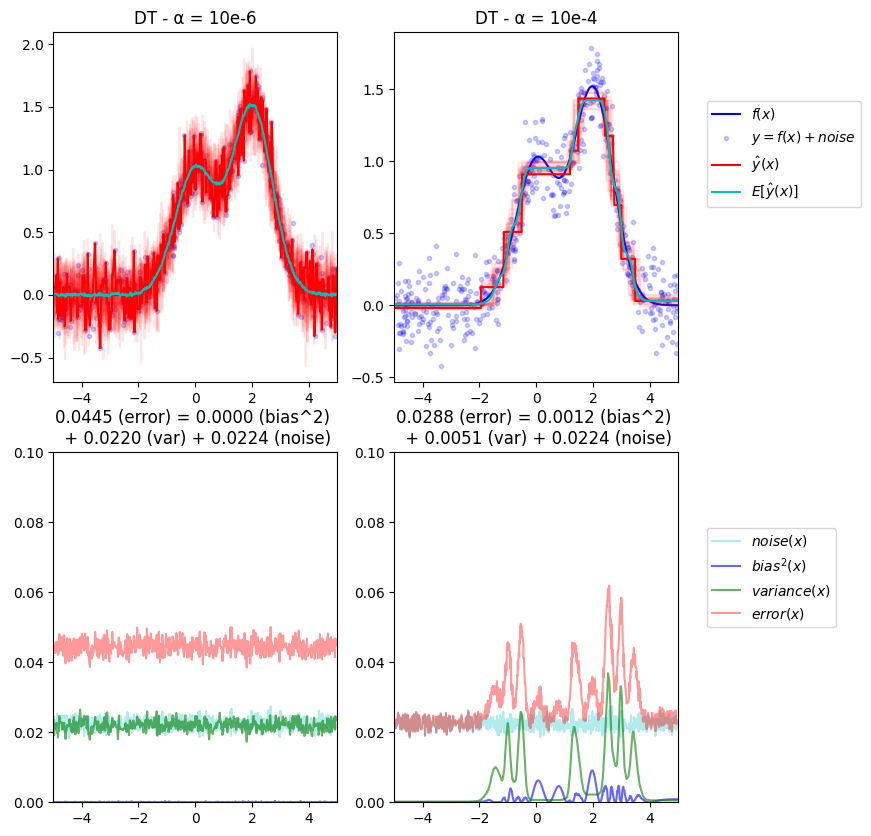

In [21]:
estimators = [("DT - α = 10e-6",   DecisionTreeRegressor(ccp_alpha=10e-6)),
              ("DT - α = 10e-4", DecisionTreeRegressor(ccp_alpha=10e-4))]

plot_simulation(estimators)

Decision tree vs. bagged trees
------------------------------

Consider the following regression models. Which model will have more bias? Which model will have more variance?

-   **Model A**: Decision tree
-   **Model B**: Ensemble of 10 trees using “bagging”

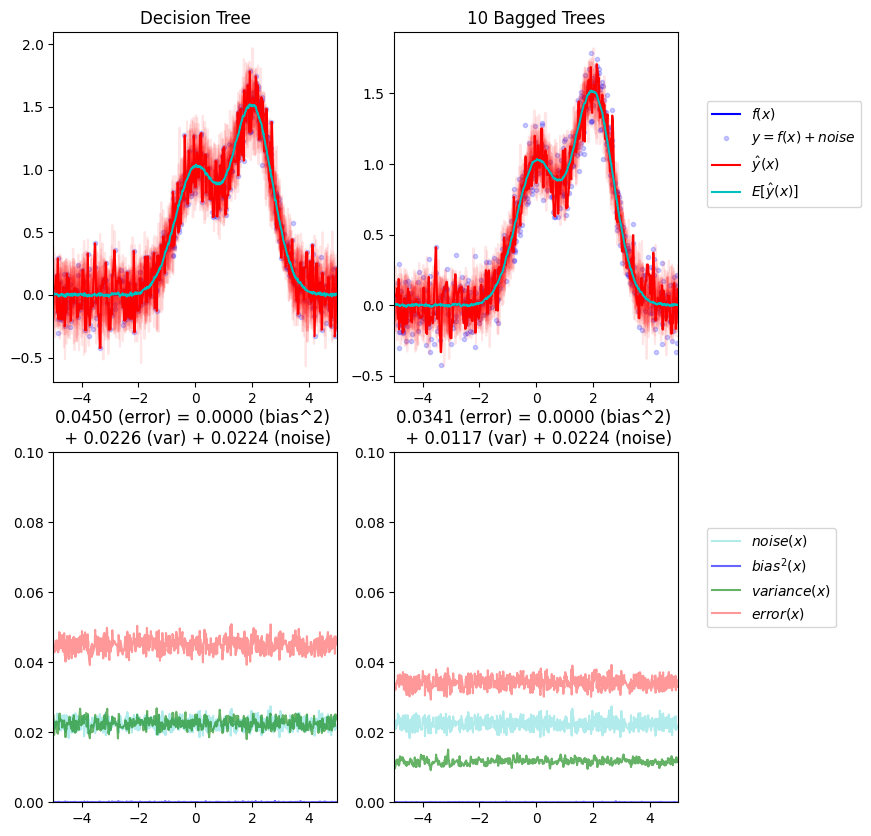

In [22]:
estimators = [("Decision Tree",   DecisionTreeRegressor()),
              ("10 Bagged Trees", BaggingRegressor(n_estimators=10, estimator=DecisionTreeRegressor()))]

plot_simulation(estimators)

Bagged trees by number of estimators
------------------------------------

Consider the following regression models. Which model will have more bias? Which model will have more variance?

-   **Model A**: Ensemble of 100 trees using “bagging”
-   **Model B**: Ensemble of 2 trees using “bagging”

Warning: this takes a long time to run!

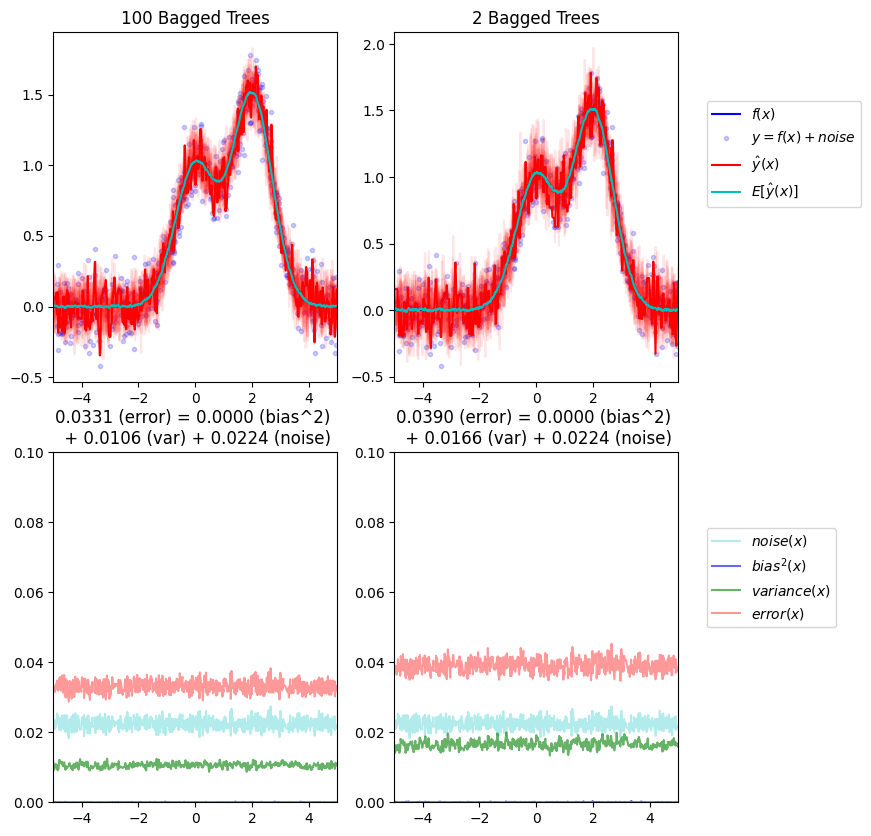

In [23]:
estimators = [("100 Bagged Trees", BaggingRegressor(n_estimators=100, estimator=DecisionTreeRegressor(), n_jobs=-1)),
              ("2 Bagged Trees", BaggingRegressor(n_estimators=2, estimator=DecisionTreeRegressor(), n_jobs=-1))]

plot_simulation(estimators)

Bagged trees by depth of base estimator
---------------------------------------

Consider the following regression models. Which model will have more bias? Which model will have more variance?

-   **Model A**: Ensemble of 10 trees, each with max depth 5, using “bagging”
-   **Model B**: Ensemble of 10 trees, each with max depth 20, using “bagging”

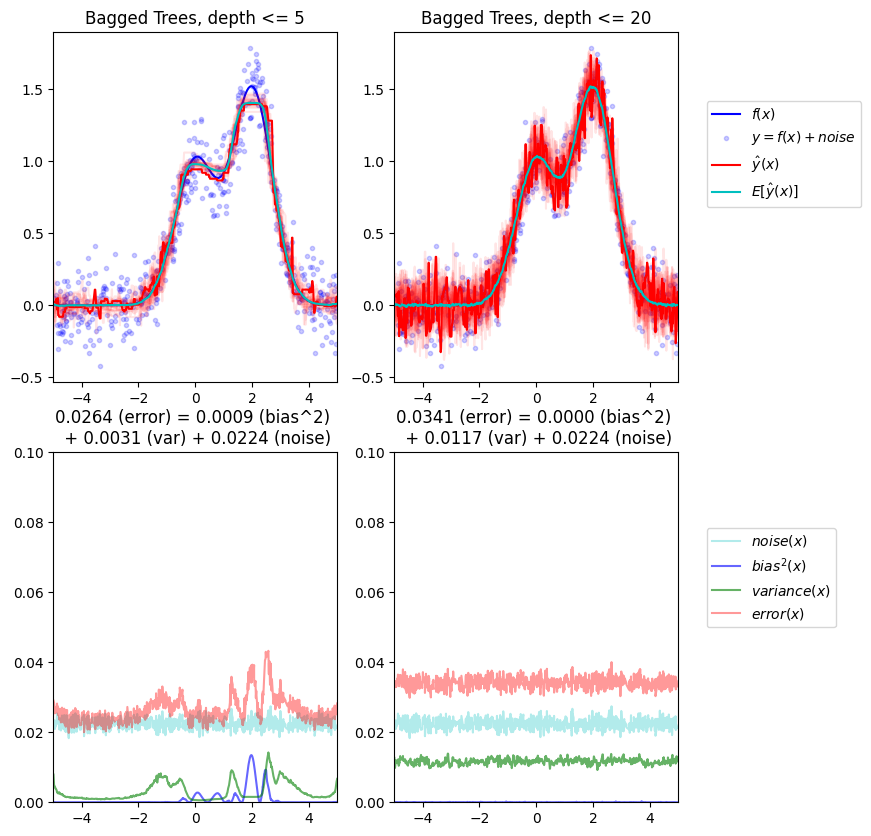

In [24]:
estimators = [("Bagged Trees, depth <= 5",  BaggingRegressor(n_estimators=10, estimator=DecisionTreeRegressor(max_depth=5))),
              ("Bagged Trees, depth <= 20", BaggingRegressor(n_estimators=10, estimator=DecisionTreeRegressor(max_depth=20)))]

plot_simulation(estimators)

Bagged trees vs. random forest
------------------------------

Consider the following regression models. Which model will have more bias? Which model will have more variance?

-   **Model A**: Ensemble of 10 trees using “bagging”
-   **Model B**: Ensemble of 10 trees using random forest

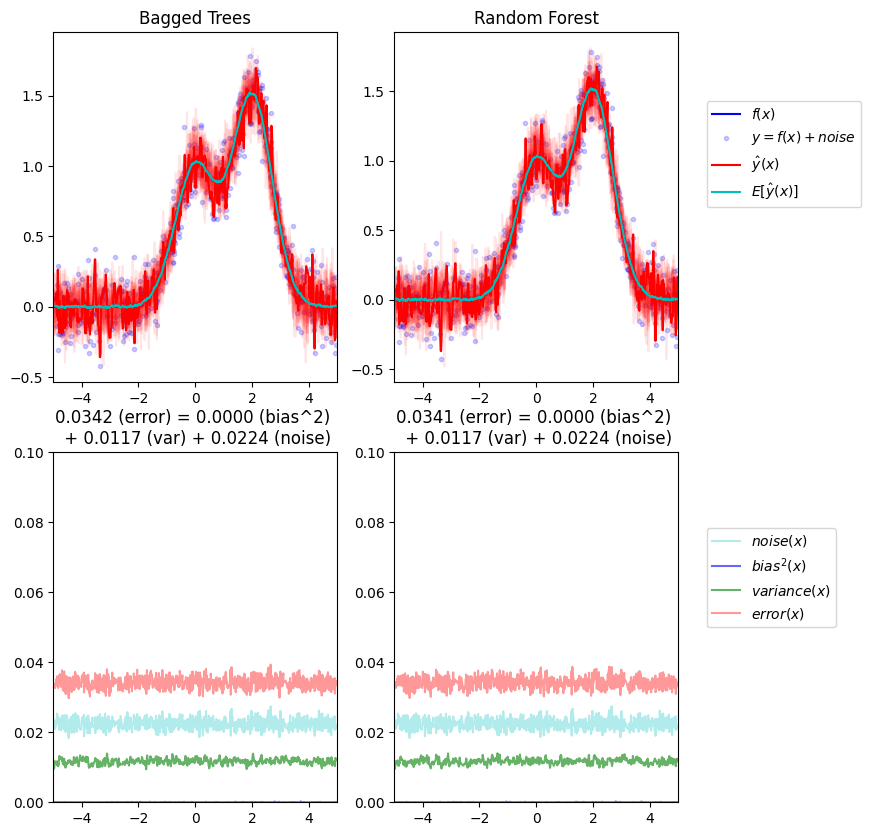

In [25]:
estimators = [("Bagged Trees", BaggingRegressor(n_estimators=10, estimator=DecisionTreeRegressor())),
              ("Random Forest",   RandomForestRegressor(n_estimators=10))]

plot_simulation(estimators)

Normally, we expect the random forest to reduce variance relative to the bagged trees! Why didn’t it have this effect in this instance?

Decision tree vs. AdaBoost
--------------------------

Consider the following regression models. Which model will have more bias? Which model will have more variance?

-   **Model A**: Decision tree with max depth 5
-   **Model B**: Ensemble of 10 trees with max depth 5, using AdaBoost

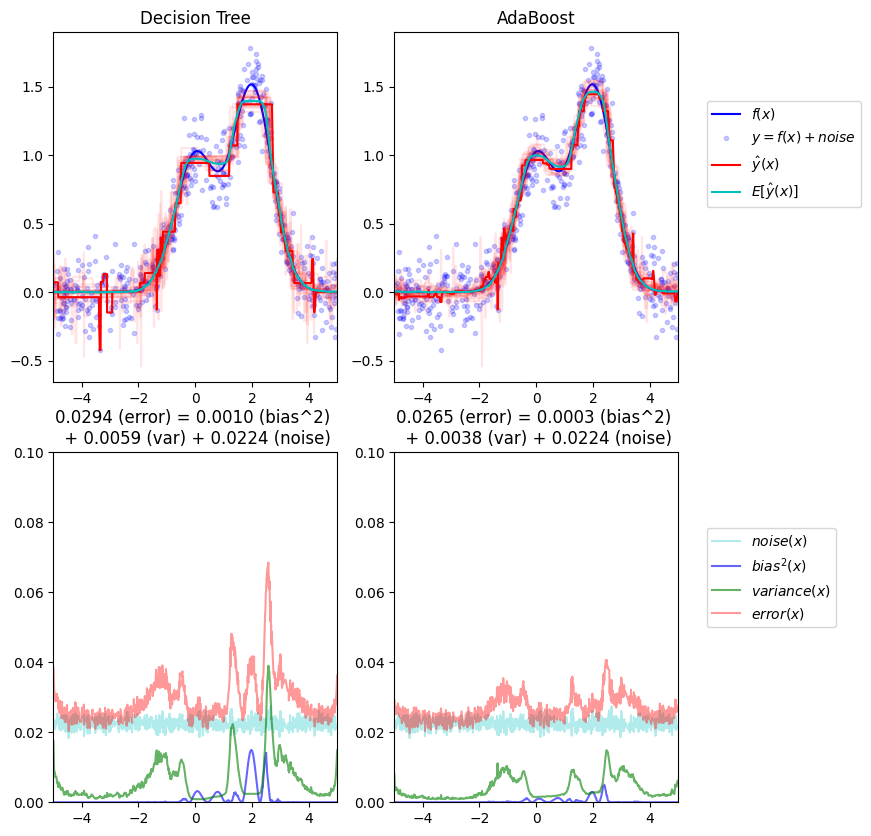

In [26]:
estimators = [("Decision Tree",   DecisionTreeRegressor(max_depth = 5)),
              ("AdaBoost", AdaBoostRegressor(n_estimators=10, estimator=DecisionTreeRegressor(max_depth=5)))]

plot_simulation(estimators)

AdaBoost by number of iterations
--------------------------------

Consider the following regression models. Which model will have more bias? Which model will have more variance?

-   **Model A**: AdaBoost ensemble after 10 iterations
-   **Model B**: AdaBoost ensemble after 100 iterations

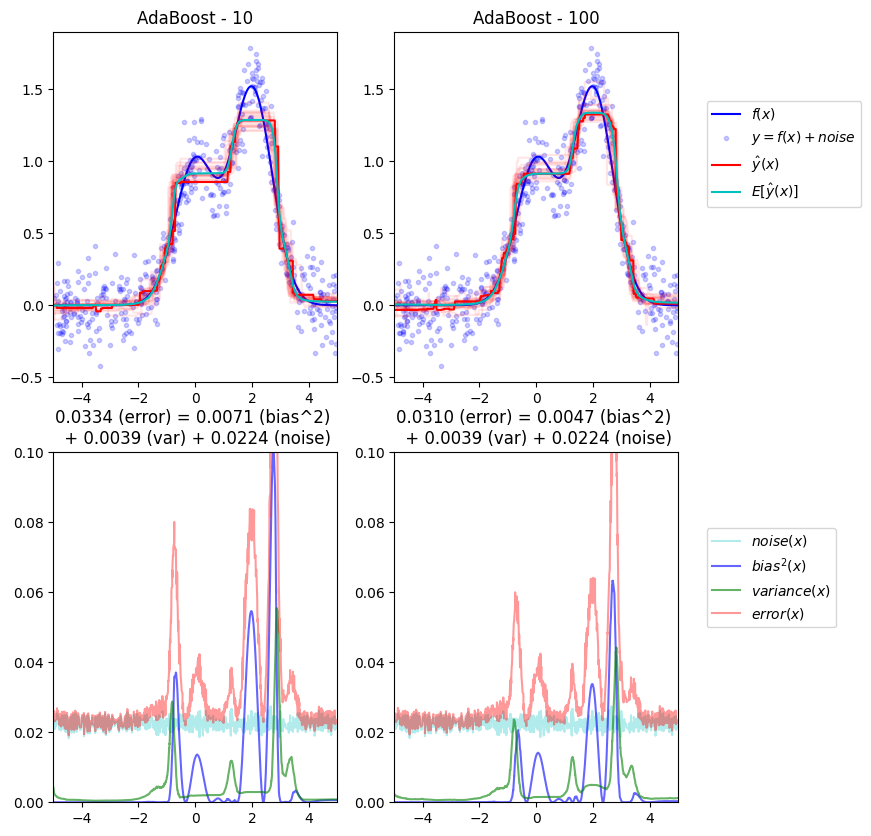

In [27]:
estimators = [("AdaBoost - 10", AdaBoostRegressor(n_estimators=10)),
              ("AdaBoost - 100", AdaBoostRegressor(n_estimators=100))]

plot_simulation(estimators)

AdaBoost by depth of base estimator
-----------------------------------

Consider the following regression models. Which model will have more bias? Which model will have more variance?

-   **Model A**: AdaBoost ensemble of trees with max depth 3
-   **Model B**: AdaBoost ensemble of trees with max depth 30

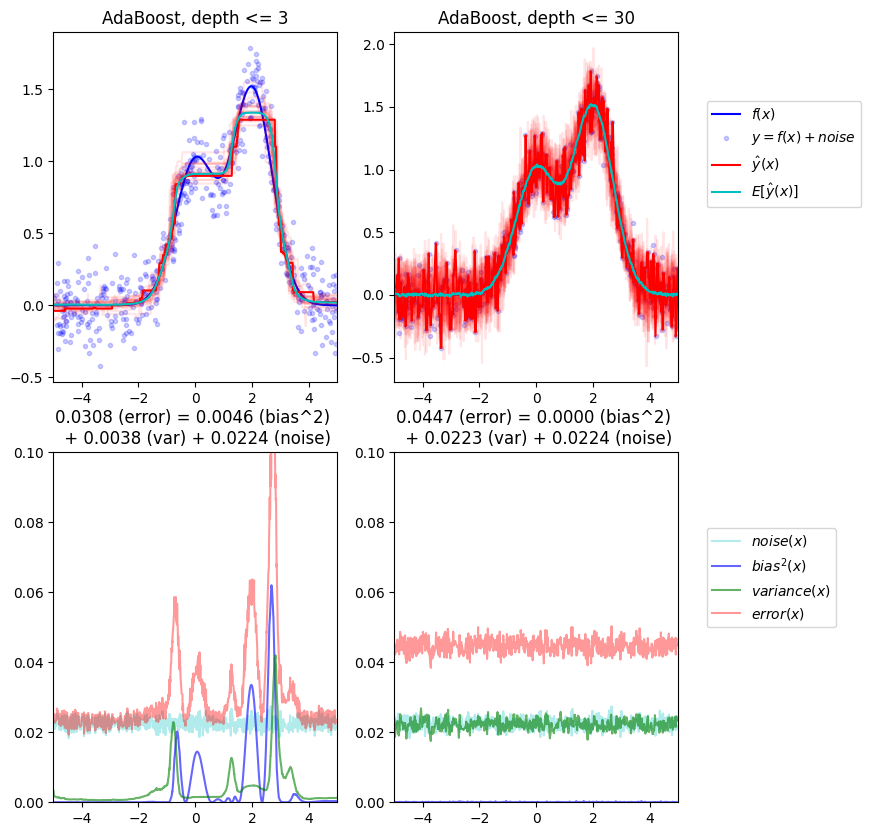

In [28]:
estimators = [("AdaBoost, depth <= 3", AdaBoostRegressor(n_estimators=50, estimator=DecisionTreeRegressor(max_depth=3))),
              ("AdaBoost, depth <= 30", AdaBoostRegressor(n_estimators=50, estimator=DecisionTreeRegressor(max_depth=30)))]

plot_simulation(estimators)